<a href="https://colab.research.google.com/github/AlejosH3/challenge2-TELECOM-X-PART-2-data-science-LATAM-/blob/main/TelecomX_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
classification_report, confusion_matrix, ConfusionMatrixDisplay,
roc_curve, auc, precision_recall_curve, average_precision_score
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

##Carga y Preprocesamiento##

In [ ]:
# URL raw del JSON
url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json"

# Obtener los datos desde la URL
response = requests.get(url)
data = response.json()

# Normalizar (aplanar) el JSON anidado
df = pd.json_normalize(data)

# Mostrar las primeras filas

display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7267 non-null   object 
 1   Churn                      7267 non-null   object 
 2   customer.gender            7267 non-null   object 
 3   customer.SeniorCitizen     7267 non-null   int64  
 4   customer.Partner           7267 non-null   object 
 5   customer.Dependents        7267 non-null   object 
 6   customer.tenure            7267 non-null   int64  
 7   phone.PhoneService         7267 non-null   object 
 8   phone.MultipleLines        7267 non-null   object 
 9   internet.InternetService   7267 non-null   object 
 10  internet.OnlineSecurity    7267 non-null   object 
 11  internet.OnlineBackup      7267 non-null   object 
 12  internet.DeviceProtection  7267 non-null   object 
 13  internet.TechSupport       7267 non-null   objec

None

In [ ]:
df = df[df['Churn'].isin(['Yes', 'No'])].copy()
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})
df['account.Charges.Total'] = pd.to_numeric(df['account.Charges.Total'], errors='coerce')
df.drop(columns=['customerID'], inplace=True)
df['Cuentas_Diarias'] = df['account.Charges.Monthly'] / 30

In [ ]:
display(df.head())
display(df.info())

,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,internet.OnlineSecurity,...,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total,Cuentas_Diarias
0,0,Female,0,Yes,Yes,9,Yes,No,DSL,No,...,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,2.186667
1,0,Male,0,No,No,9,Yes,Yes,DSL,No,...,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,1.996667
2,1,Male,0,No,No,4,Yes,No,Fiber optic,No,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,2.463333
3,1,Male,1,Yes,No,13,Yes,No,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,3.266667
4,1,Female,1,Yes,No,3,Yes,No,Fiber optic,No,...,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,2.796667


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Churn                      7043 non-null   int64  
 1   customer.gender            7043 non-null   object 
 2   customer.SeniorCitizen     7043 non-null   int64  
 3   customer.Partner           7043 non-null   object 
 4   customer.Dependents        7043 non-null   object 
 5   customer.tenure            7043 non-null   int64  
 6   phone.PhoneService         7043 non-null   object 
 7   phone.MultipleLines        7043 non-null   object 
 8   internet.InternetService   7043 non-null   object 
 9   internet.OnlineSecurity    7043 non-null   object 
 10  internet.OnlineBackup      7043 non-null   object 
 11  internet.DeviceProtection  7043 non-null   object 
 12  internet.TechSupport       7043 non-null   object 
 13  internet.StreamingTV       7043 non-null   object 
 1

None

###Encoding###

In [ ]:
df = pd.get_dummies(df, drop_first=True)
display(df.head())
display(df.info())

,Churn,customer.SeniorCitizen,customer.tenure,account.Charges.Monthly,account.Charges.Total,Cuentas_Diarias,customer.gender_Male,customer.Partner_Yes,customer.Dependents_Yes,phone.PhoneService_Yes,...,internet.StreamingTV_No internet service,internet.StreamingTV_Yes,internet.StreamingMovies_No internet service,internet.StreamingMovies_Yes,account.Contract_One year,account.Contract_Two year,account.PaperlessBilling_Yes,account.PaymentMethod_Credit card (automatic),account.PaymentMethod_Electronic check,account.PaymentMethod_Mailed check
0,0,0,9,65.6,593.30,2.186667,False,True,True,True,...,False,True,False,False,True,False,True,False,False,True
1,0,0,9,59.9,542.40,1.996667,True,False,False,True,...,False,False,False,True,False,False,False,False,False,True
2,1,0,4,73.9,280.85,2.463333,True,False,False,True,...,False,False,False,False,False,False,True,False,True,False
3,1,1,13,98.0,1237.85,3.266667,True,True,False,True,...,False,True,False,True,False,False,True,False,True,False
4,1,1,3,83.9,267.40,2.796667,False,True,False,True,...,False,True,False,False,False,False,True,False,False,True


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0 to 7266
Data columns (total 32 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Churn                                          7043 non-null   int64  
 1   customer.SeniorCitizen                         7043 non-null   int64  
 2   customer.tenure                                7043 non-null   int64  
 3   account.Charges.Monthly                        7043 non-null   float64
 4   account.Charges.Total                          7032 non-null   float64
 5   Cuentas_Diarias                                7043 non-null   float64
 6   customer.gender_Male                           7043 non-null   bool   
 7   customer.Partner_Yes                           7043 non-null   bool   
 8   customer.Dependents_Yes                        7043 non-null   bool   
 9   phone.PhoneService_Yes                         7043 non-n

None

###Verificación de la Proporción de Cancelación (Churn)##

In [ ]:
conteo = df['Churn'].value_counts()
proporcion = df['Churn'].value_counts(normalize=True)

# Mostrar resultados
print("📊 Conteo de clases:")
print(conteo)
print("\n📈 Proporción de clases:")
print(proporcion)

# Evaluar si hay desbalance
if proporcion.min() < 0.4:
    print("\n⚠️ Existe un desbalance de clases, considera técnicas para tratarlo.")
else:
    print("\n✅ Las clases están relativamente balanceadas.")

📊 Conteo de clases:
Churn
0    5174
1    1869
Name: count, dtype: int64

📈 Proporción de clases:
Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64

⚠️ Existe un desbalance de clases, considera técnicas para tratarlo.


##🎯 Correlación y Selección de Variables##

###Analisis de correlacion###

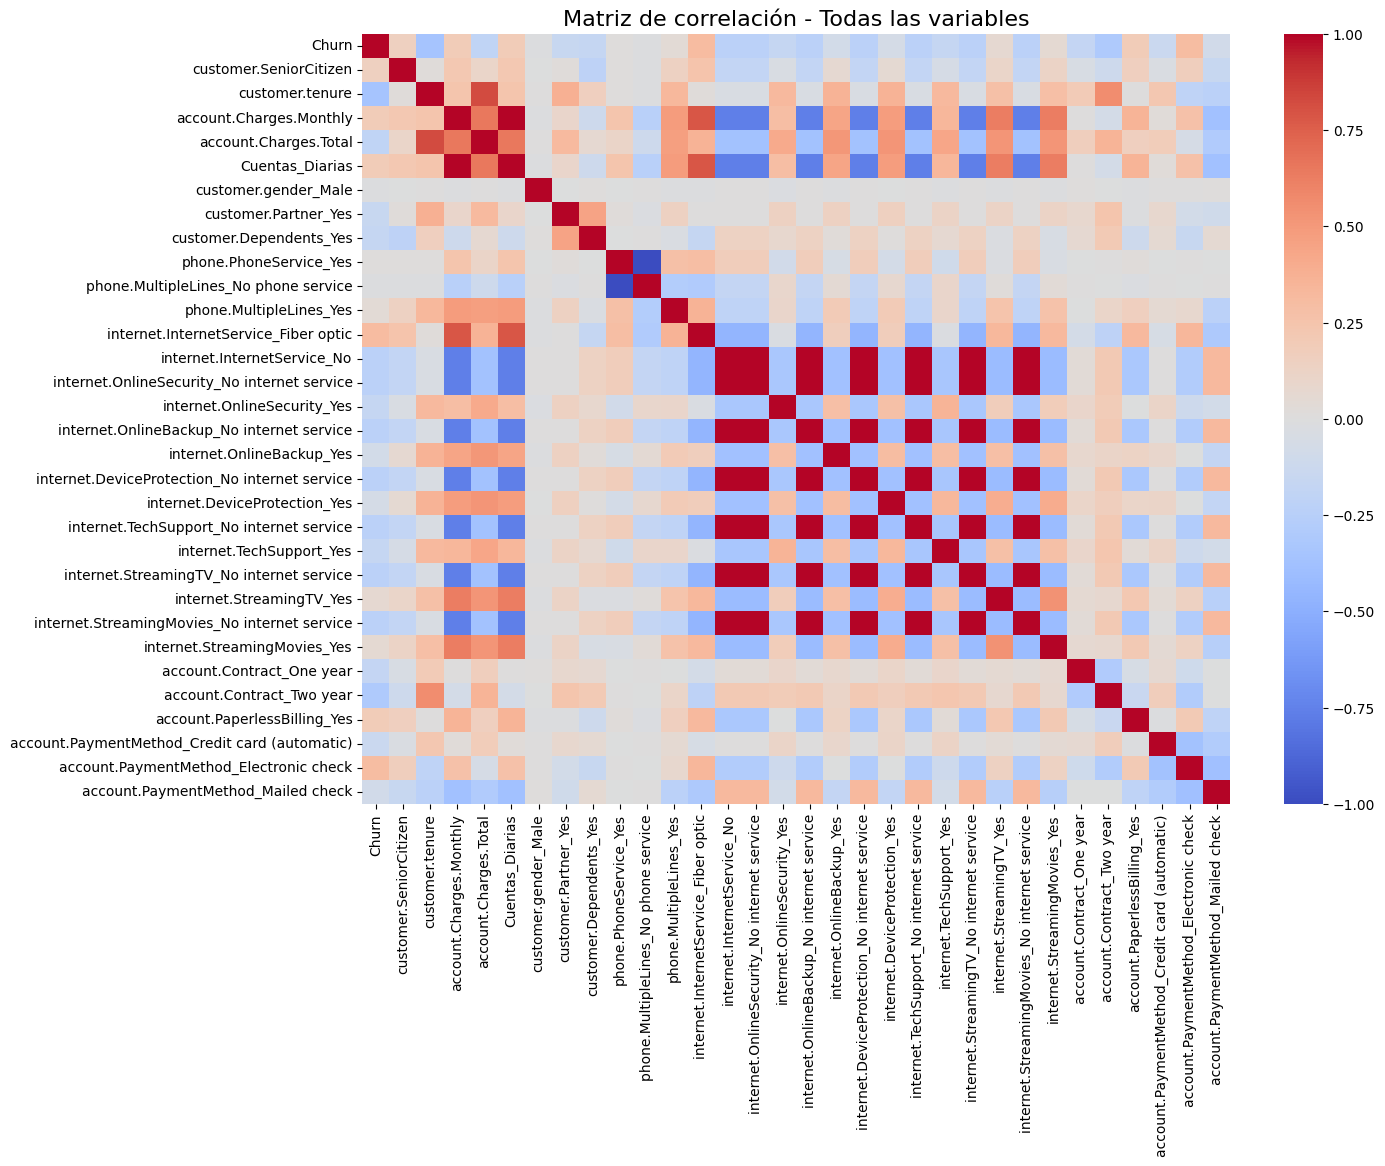

📊 Correlación de variables con Churn:
Churn                                            1.000000
internet.InternetService_Fiber optic             0.308020
account.PaymentMethod_Electronic check           0.301919
account.Charges.Monthly                          0.193356
Cuentas_Diarias                                  0.193356
account.PaperlessBilling_Yes                     0.191825
customer.SeniorCitizen                           0.150889
internet.StreamingTV_Yes                         0.063228
internet.StreamingMovies_Yes                     0.061382
phone.MultipleLines_Yes                          0.040102
phone.PhoneService_Yes                           0.011942
customer.gender_Male                            -0.008612
phone.MultipleLines_No phone service            -0.011942
internet.DeviceProtection_Yes                   -0.066160
internet.OnlineBackup_Yes                       -0.082255
account.PaymentMethod_Mailed check              -0.091683
account.PaymentMethod_Credit card 

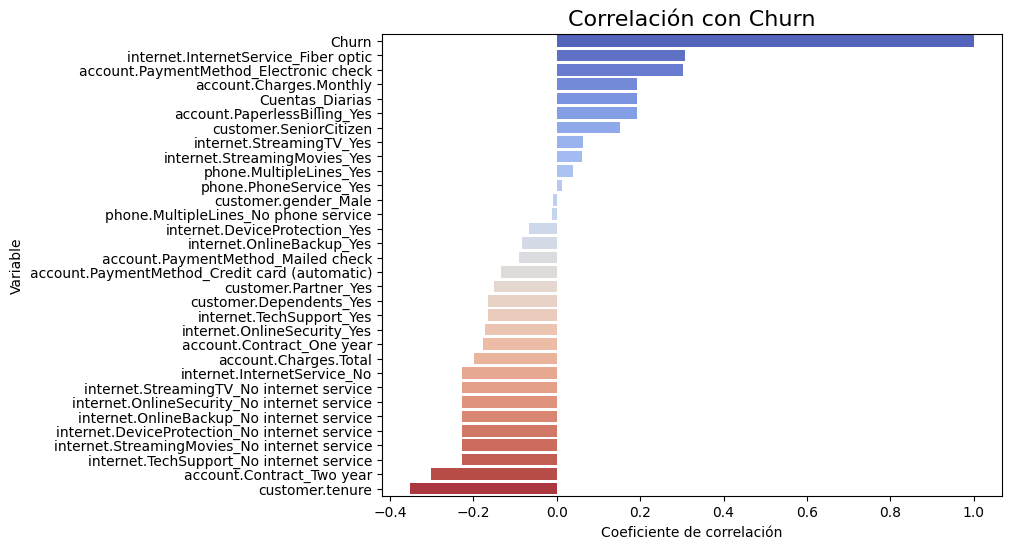

In [ ]:
# Calcular la matriz de correlación
corr_matrix = df.corr(numeric_only=True)

# Visualizar la matriz completa
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False)
plt.title("Matriz de correlación - Todas las variables", fontsize=16)
plt.show()

# Ver correlaciones de cada variable con la variable objetivo 'Churn'
corr_target = corr_matrix['Churn'].sort_values(ascending=False)
print("📊 Correlación de variables con Churn:")
print(corr_target)

# Visualizar solo las correlaciones con Churn
plt.figure(figsize=(8, 6))
sns.barplot(x=corr_target.values, y=corr_target.index, palette='coolwarm')
plt.title("Correlación con Churn", fontsize=16)
plt.xlabel("Coeficiente de correlación")
plt.ylabel("Variable")
plt.show()


###Análisis Dirigido###

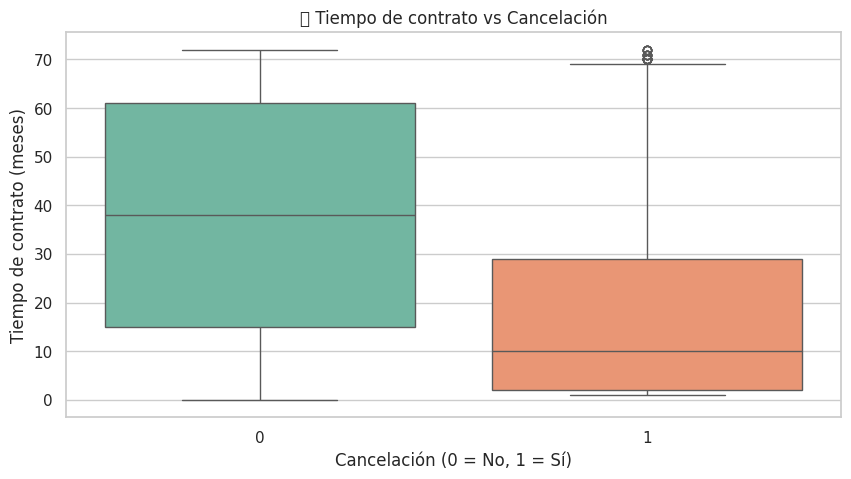

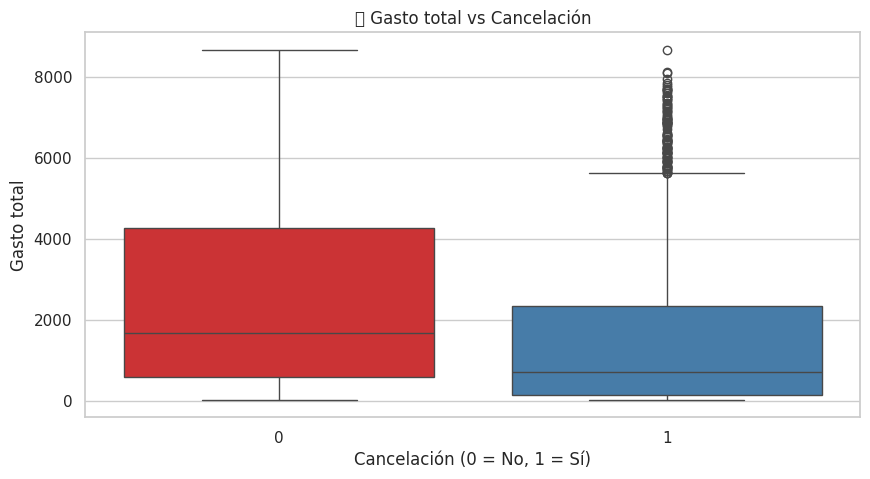

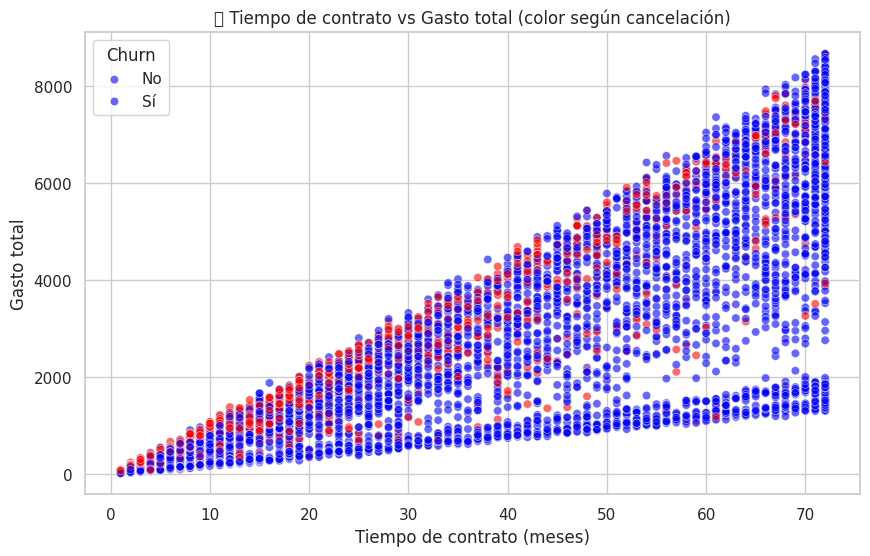

In [ ]:
# Ajustar estilo de gráficos
sns.set(style="whitegrid")

# Boxplot: Tiempo de contrato vs Cancelación
plt.figure(figsize=(10,5))
sns.boxplot(x="Churn", y="customer.tenure", data=df, palette="Set2")
plt.title("⏳ Tiempo de contrato vs Cancelación")
plt.xlabel("Cancelación (0 = No, 1 = Sí)")
plt.ylabel("Tiempo de contrato (meses)")
plt.show()

# Boxplot: Gasto total vs Cancelación
plt.figure(figsize=(10,5))
sns.boxplot(x="Churn", y="account.Charges.Total", data=df, palette="Set1")
plt.title("💰 Gasto total vs Cancelación")
plt.xlabel("Cancelación (0 = No, 1 = Sí)")
plt.ylabel("Gasto total")
plt.show()

# Scatter plot: Tiempo de contrato vs Gasto total, coloreado por Churn
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="customer.tenure",
    y="account.Charges.Total",
    hue="Churn",
    data=df,
    palette={0: "blue", 1: "red"},
    alpha=0.6
)
plt.title("📈 Tiempo de contrato vs Gasto total (color según cancelación)")
plt.xlabel("Tiempo de contrato (meses)")
plt.ylabel("Gasto total")
plt.legend(title="Churn", labels=["No", "Sí"])
plt.show()


In [ ]:
top_features = df.corr()['Churn'].abs().sort_values(ascending=False).iloc[1:11].index.tolist()
X, y = df[top_features], df['Churn']

##🤖 Modelado Predictivo##

###Pipeline SMOTE y seleccion de algoritmo de ML (RandomForest)

In [ ]:
pipeline = Pipeline([
('imputer', SimpleImputer(strategy='mean')),
('smote', SMOTE(random_state=42)),
('rf', RandomForestClassifier(random_state=42))
])

###Busca aleatoria de hiperparametros###

In [ ]:
param_dist = {
'rf__n_estimators': [100, 300, 500],
'rf__max_depth': [10, 30, None],
'rf__min_samples_split': [2, 5],
'rf__min_samples_leaf': [1, 2],
'rf__max_features': ['sqrt', 'log2']
}
search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=30,
scoring='f1', cv=5, random_state=42, n_jobs=-1, verbose=0)
search.fit(X, y)
best_pipeline = search.best_estimator_

###Evaluación de los Modelos###

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for metric in ['accuracy', 'precision', 'recall', 'f1']:
  scores = cross_val_score(best_pipeline, X, y, cv=cv, scoring=metric)
  print(f"{metric.capitalize():<10}: Média = {scores.mean():.4f} | Desvio = {scores.std():.4f}")

Accuracy  : Média = 0.7433 | Desvio = 0.0059
Precision : Média = 0.5109 | Desvio = 0.0073
Recall    : Média = 0.7640 | Desvio = 0.0346
F1        : Média = 0.6121 | Desvio = 0.0144


###Graficos y evaluacion###

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
best_pipeline.fit(X_train, y_train)
y_pred = best_pipeline.predict(X_test)
y_prob = best_pipeline.predict_proba(X_test)[:, 1]

####Matriz de confusion####

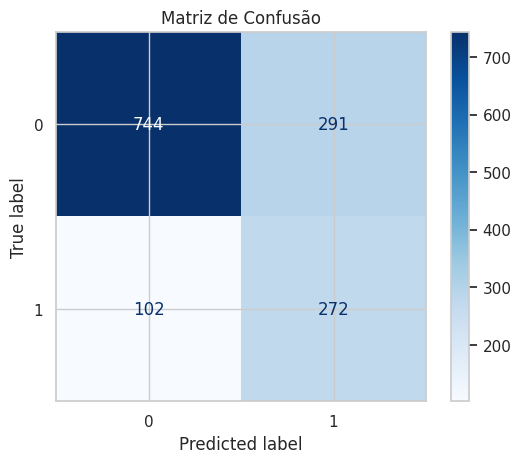


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.72      0.79      1035
           1       0.48      0.73      0.58       374

    accuracy                           0.72      1409
   macro avg       0.68      0.72      0.69      1409
weighted avg       0.77      0.72      0.74      1409



In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(cmap="Blues")
plt.title("Matriz de Confusão")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

####ROC####

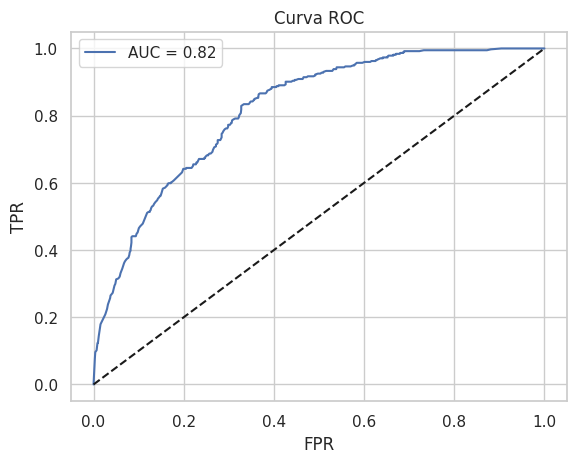

(<matplotlib.legend.Legend at 0x79ed13a72a10>, None, None)

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("FPR"), plt.ylabel("TPR")
plt.title("Curva ROC")
plt.legend(), plt.grid(True), plt.show()

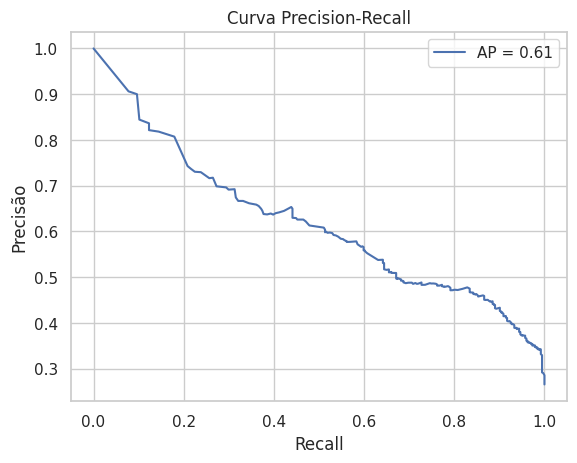

(<matplotlib.legend.Legend at 0x79ed13a6b710>, None, None)

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.plot(recall, precision, label=f"AP = {average_precision_score(y_test, y_prob):.2f}")
plt.xlabel("Recall"), plt.ylabel("Precisão")
plt.title("Curva Precision-Recall")
plt.legend(), plt.grid(True), plt.show()

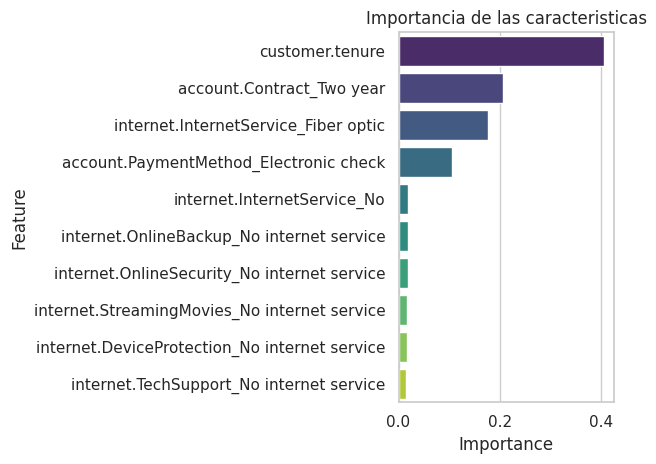

In [ ]:
rf_model = best_pipeline.named_steps['rf']
feat_imp = pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_})
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)

sns.barplot(data=feat_imp, x='Importance', y='Feature', palette='viridis')
plt.title('Importancia de las caracteristicas')
plt.tight_layout()
plt.show()

## 📝 Informe Detallado: Análisis de Churn y Estrategias de Retención

Basándonos en el análisis exploratorio, la selección de variables y la evaluación del modelo predictivo, hemos identificado los siguientes factores clave que influyen en la cancelación de clientes y proponemos estrategias para mitigarla.

### Factores Clave que Influyen en la Cancelación

Según el análisis de correlación y la importancia de las características obtenida del modelo Random Forest, los factores que más impactan en la probabilidad de que un cliente cancele son:

1.  **Tiempo de Contrato (customer.tenure):** Existe una correlación negativa significativa. Los clientes con menor tiempo de contrato son más propensos a cancelar. Esto se visualiza claramente en el boxplot donde los clientes que cancelan tienen una menor mediana de tiempo de contrato.
2.  **Tipo de Contrato (account.Contract_Two year):** Los clientes con contratos a dos años tienen una menor probabilidad de cancelar, lo que se refleja en la correlación negativa. Los contratos a corto plazo (mes a mes) presentan una mayor tasa de churn.
3.  **Servicio de Internet (internet.InternetService_Fiber optic y internet.InternetService_No):** Los clientes con servicio de Fibra Óptica tienen una mayor probabilidad de cancelar, mientras que aquellos sin servicio de internet tienen una menor probabilidad. Esto sugiere que la calidad o el costo del servicio de fibra óptica pueden ser factores de insatisfacción.
4.  **Método de Pago (account.PaymentMethod_Electronic check):** Los clientes que utilizan el pago electrónico tienen una mayor probabilidad de cancelar. Esto podría estar relacionado con la facilidad para cambiar de proveedor o con problemas específicos asociados a este método de pago.
5. **Cargos Totales (account.Charges.Total):** Los clientes con menores cargos totales tienen una mayor probabilidad de cancelar. Esto puede estar relacionado con el tiempo de contrato, ya que a menor tiempo, menores cargos totales.

### Evaluación del Modelo Predictivo

El modelo Random Forest, optimizado mediante búsqueda aleatoria y utilizando SMOTE para abordar el desbalance de clases, muestra un rendimiento aceptable para la predicción de churn.

*   **Métricas de Cross-Validation:**
    *   Accuracy: 0.7433
    *   Precision: 0.5109
    *   Recall: 0.7640
    *   F1-Score: 0.6121

*   **Métricas en el Conjunto de Prueba:**
    *   Accuracy: 0.72
    *   Precision: 0.48
    *   Recall: 0.73
    *   F1-Score: 0.58
    *   AUC: 0.82
    *   AP: 0.61

La matriz de confusión y el classification report en el conjunto de prueba indican que el modelo tiene una buena capacidad para identificar a los clientes que van a cancelar (Recall = 0.73), lo cual es crucial para las estrategias de retención. Sin embargo, la precisión (0.48) sugiere que hay un número significativo de falsos positivos (clientes predichos como churn que no cancelan). Esto es un *trade-off* común al tratar con desbalance de clases y priorizar la identificación de la minoría.

La curva ROC con un AUC de 0.82 indica que el modelo distingue razonablemente bien entre las clases. La curva Precision-Recall con un AP de 0.61 también valida el rendimiento del modelo en un contexto de desbalance.

### Estrategias de Retención Propuestas

Basándonos en los factores identificados, proponemos las siguientes estrategias de retención:

1.  **Fidelización de Clientes Jóvenes (en tiempo de contrato):** Implementar programas de bienvenida y seguimiento intensivo para clientes con poco tiempo de contrato. Ofrecer incentivos especiales o beneficios adicionales para fomentar la permanencia inicial.
2.  **Promoción de Contratos a Largo Plazo:** Incentivar a los clientes a optar por contratos de mayor duración (dos años) mediante descuentos o beneficios exclusivos. Comunicar claramente los beneficios de los contratos a largo plazo.
3.  **Mejora del Servicio de Fibra Óptica:** Investigar las causas de la mayor tasa de churn entre los usuarios de fibra óptica. Esto podría implicar mejoras en la calidad del servicio, soporte técnico más eficiente o ajustes en la tarificación.
4.  **Análisis de Métodos de Pago Electrónico:** Investigar si existen problemas específicos con el método de pago electrónico que estén generando insatisfacción. Podría ser necesario optimizar la plataforma de pago o ofrecer alternativas más atractivas.
5.  **Análisis Segmentado por Gasto Total:** Si bien los clientes con menores cargos totales cancelan más, es importante analizar si esto se debe únicamente al tiempo de contrato o si hay otros factores asociados a este segmento que deban abordarse.

### Próximos Pasos

*   Realizar un análisis más profundo de los segmentos de clientes identificados como de alto riesgo (por ejemplo, usuarios de fibra óptica con pago electrónico y poco tiempo de contrato).
*   Desarrollar e implementar las estrategias de retención propuestas, midiendo su impacto en la tasa de churn.
*   Continuar monitoreando el rendimiento del modelo y reentrenarlo periódicamente con nuevos datos.
*   Considerar la exploración de otros modelos o técnicas de balanceo de clases para buscar posibles mejoras en la precisión sin sacrificar demasiado recall.